# Euler versus Velocity-Verlet

We would like to investigate the difference between integrating Newton's second law in an N-body problem using Euler's algorithm and the velocity-Verlet algortihm introduces in the lecture notes.

To do so, we will study a well known and tractable N-body problem, the gravitational (N=2) earth-sun problem. This is also known as Kepler's problem. 

**Note:** In what follows, we will set up a piece of code that solves the earth-sun problem and illustrate the effect of using different integration methods. While it can be extended to more than 2 bodies, and will certainly still run for a few extra planets and moons, it is not set up in a particularly efficient way! The usage of a class is (debatably) reasonable when there are a few bodies with specific identities you would like to keep track of, but not very well suited for thousands of anonymous and nominally identical particles. Furthermore, the usage of clever scipy functions or numpy linear algebra is rather minimal, which leads to inefficient nested structures. Can you spot the number of loops (often inside loops!) for the velocity-Verlet section? And what about the functions not taking any inputs or having any outputs?

In fact, quite a few of the choices made here are suboptimal. When writing your own code, try to address these issues; your code will become much faster and your life will become a lot easier!

As always, we begin with the relevant imports.

In [44]:
import numpy as np
from matplotlib import pyplot as plt

In order to eliminate the dimensions from our simulation we define typical scales of quantities for the earth-sun problem and rescale accordingly. 

In [45]:
day = 60*60*24 #length of an earth-day in s
au = 1.496e11 #a single astronomical unit in m
m_sol = 1.989e30 #mass of the sun in kg


#rescaling the relevant parameters
m_earth = 5.9742e24/m_sol #mass of the earth in units of m_sol
v_earth =  29783/au*day ##average orbital velocity of the earth in au/day
G = 6.67408e-11/au**3*m_sol*day**2 #gravtitational constant in au^3/m_sol/day^2
eps = m_sol*au**2/day**2 #typical energy scale in these units; a rather large number!

We set up a generic class that handles the parameters for the N bodies under study.

In [46]:
class CelestialBody(object):
    """Set up a celestial body to be included in the 3D gravitational N-body problem.

    Keyword arguments:
    id -- an id used to track the body (int)
    name -- the name used to label the body (str)
    x0 -- initial position of the body in au (list)
    v0 -- initial velocity of the body in au/day (list)
    mass -- mass of the body in solar masses (float)
    color -- color used to plot quantities relating to the body (str)
    lw -- linewidth used to plot quantities relating to the body (float)
    """
    
    def __init__(self, id, name, x0, v0, mass, color, lw):
        
        self.id = id
        self.name = name 
        self.x0 = np.asarray(x0, dtype=float)
        self.v0 = np.asarray(v0, dtype=float)
        self.M = mass
        self.color = color
        self.lw = lw
        
        #initialize the relevant parameters we keep track of
        self.x = self.x0.copy()
        self.v = self.v0.copy()
        self.a = np.zeros([3], dtype=float)
        self.Ekin = 0.
        self.Epot = 0.


We define the functions that calculate the quantities of interest

In [47]:
def calc_force():
    """Calculate the forces acting on body i"""
    for body in bodies:
        body.a *= 0
        for other in bodies:            
            if (body == other): 
                continue # no force acting on itself
            rx = body.x - other.x
            r3 = np.sum(rx**2)**1.5
            body.a += -G*other.M*rx/r3
            
def calc_potential_energy():
    """Calculate potential energy of body i"""
    for body in bodies:
        body.Epot *= 0
        for other in bodies:            
            if (body == other): 
                continue # no force acting on itself
            rx = body.x - other.x
            r = np.sum(rx**2)**0.5
            body.Epot += -G*body.M*other.M/r/2    

def calc_kinetic_energy():
    """Calculate kinetic energy of body i"""
    for body in bodies:
        body.Ekin = body.M*np.sum(body.v**2)

## Euler method

We initialize the problem and the lists keeping track of the data

In [48]:
bodies = [
    CelestialBody(0, 'Sun', [0.0, 0, 0], [0, 0, 0.0], 1.0, 'blue', 3),
    CelestialBody(1, 'Earth', [-1, 0, 0], [0, v_earth, 0], m_earth, 'red', 1) 
    ]

#we find the initial values of the potential and kinetic energy before we begin the actual simulation
calc_potential_energy()
calc_kinetic_energy()
        
paths = [[b.x.copy()] for b in bodies]
Ekins = [[b.Ekin] for b in bodies]
Epots = [[b.Epot] for b in bodies]     

We run the simulation using Euler's algorithm

In [49]:
t = 0
dt = 1 #timestep in number of days

while t < 10*365: #simulate for around 10 years
    for n, planet in enumerate(bodies):
        #implementing Euler's algorithm
        calc_force()
        planet.x += planet.v*dt
        planet.v += planet.a*dt
        
        #updating quantities being tracked
        calc_potential_energy()
        calc_kinetic_energy()
        paths[n].append(planet.x.copy())
        Ekins[n].append(planet.Ekin)
        Epots[n].append(planet.Epot)
    t += dt

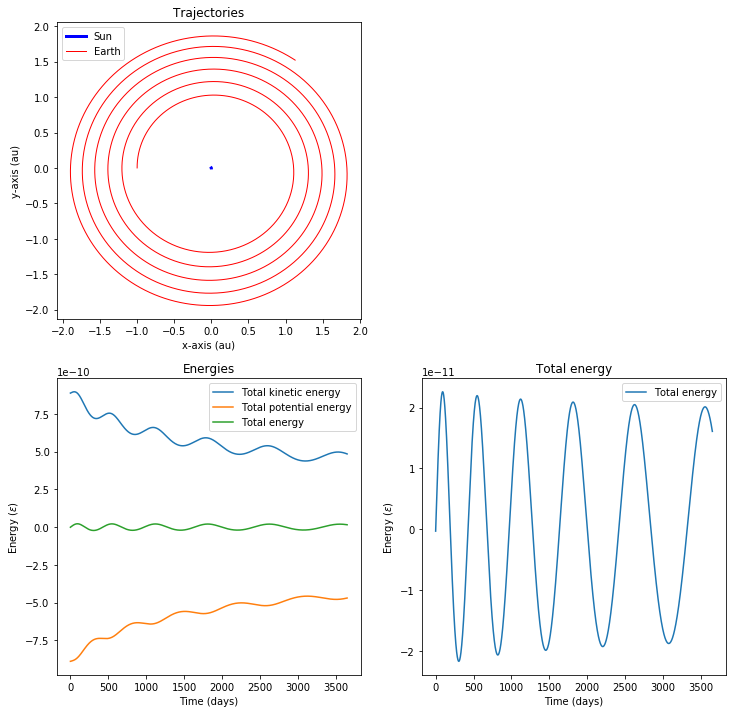

In [50]:
Ekin = np.sum(np.array(Ekins), axis=0)
Epot = np.sum(np.array(Epots), axis=0)
Etot = np.sum(np.array(Ekins)+np.array(Epots), axis=0)

plt.figure(figsize=(12,12))
plt.subplot(221)
for n, planet in enumerate(bodies): 
    px, py, pz = np.array(paths[n]).T; 
    plt.plot(px, py, color=planet.color, lw=planet.lw, label=planet.name)
plt.xlabel('x-axis (au)')
plt.ylabel('y-axis (au)')
plt.legend()
plt.title('Trajectories')
plt.subplot(223)
plt.plot(Ekin, label='Total kinetic energy')
plt.plot(Epot, label='Total potential energy')
plt.plot(Etot, label='Total energy')
plt.title('Energies')
plt.xlabel('Time (days)')
plt.ylabel(r'Energy ($\epsilon$)')
plt.legend()
plt.subplot(224)
plt.plot(Etot, label='Total energy')
plt.xlabel('Time (days)')
plt.title('Total energy')
plt.ylabel(r'Energy ($\epsilon$)')
plt.legend()
plt.savefig('figures/euler.png', dpi=400)
plt.show()



We notice two things: first of all, we do not obtain a nice, stable orbit. The earth seems to be slowly spiralling into the sun, which we know is not correct! But the energies also reveal something: the total energy of the system does not seem to be constant, but instead oscillates with fluctuations that are quite sizeable compared to the kinetic and potential energy in the system. This is a sign of something going wrong, as energy is supposed to be conserved. 

Now, we could probably improve things by reducing our (arguably large) time step size. Instead, we'll have a look at the exact same problem using Verlet's algorithm.

## Velocity-Verlet

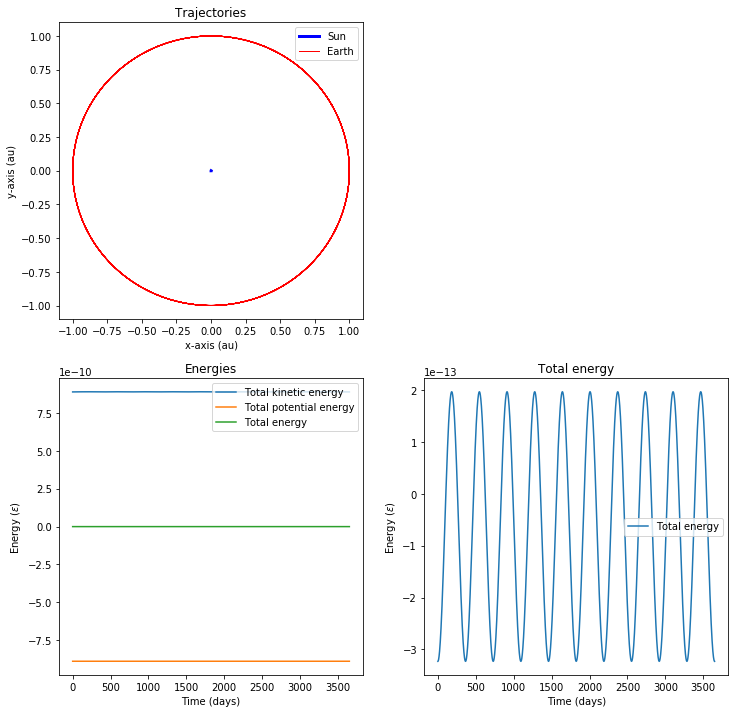

In [51]:
bodies = [
    CelestialBody(0, 'Sun', [0.0, 0, 0], [0, 0, 0.0], 1.0, 'blue', 3),
    CelestialBody(1, 'Earth', [-1, 0, 0], [0, v_earth, 0], m_earth, 'red', 1)]

#we find the initial values of the potential and kinetic energy before we begin the actual simulation
calc_potential_energy()
calc_kinetic_energy()
        
paths = [[b.x.copy()] for b in bodies]
Ekins = [[b.Ekin] for b in bodies]
Epots = [[b.Epot] for b in bodies]     

#run the simulation
t = 0
dt = 1 #timestep in number of days

while t < 10*365: #simulate for around 10 years
    for n, planet in enumerate(bodies):
        #implementing Verlet's algorithm
        calc_force()
        planet.x += planet.v*dt+planet.a*dt**2/2
        planet.v += planet.a*dt/2
        calc_force()
        planet.v += planet.a*dt/2
        
        #updating quantities being tracked
        calc_potential_energy()
        calc_kinetic_energy()
        paths[n].append(planet.x.copy())
        Ekins[n].append(planet.Ekin)
        Epots[n].append(planet.Epot)
    t += dt
    
    
Ekin = np.sum(np.array(Ekins), axis=0)
Epot = np.sum(np.array(Epots), axis=0)
Etot = np.sum(np.array(Ekins)+np.array(Epots), axis=0)

plt.figure(figsize=(12,12))
plt.subplot(221)
for n, planet in enumerate(bodies): 
    px, py, pz = np.array(paths[n]).T; 
    plt.plot(px, py, color=planet.color, lw=planet.lw, label=planet.name)
plt.xlabel('x-axis (au)')
plt.ylabel('y-axis (au)')
plt.legend()
plt.title('Trajectories')
plt.subplot(223)
plt.plot(Ekin, label='Total kinetic energy')
plt.plot(Epot, label='Total potential energy')
plt.plot(Etot, label='Total energy')
plt.title('Energies')
plt.xlabel('Time (days)')
plt.ylabel(r'Energy ($\epsilon$)')
plt.legend()
plt.subplot(224)
plt.plot(Etot, label='Total energy')
plt.xlabel('Time (days)')
plt.title('Total energy')
plt.ylabel(r'Energy ($\epsilon$)')
plt.legend()
plt.savefig('figures/verlet.png', dpi=400)
plt.show()



Using the same timestep as before, the velocity-Verlet method results in a stable orbit around the sun, which is a more familiar sight. Moreover, the total energy of the system is now much more well behaved; on the scale of the other energies in the system it appears very stable, and upon zooming in we find that the magnitude of oscillations are 2 orders of magnitude lower than when using Euler's method.